<a href="https://colab.research.google.com/github/rrrJiia/CS-Courses-at-Gatech/blob/CS4650_nlp/CS4650_p1_NBOW_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 0. Google Colab Setup

Welcome to the first full programming project for CS 4650! If you're new to Google Colab we recommend looking at [this](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) intro notebook before getting started with this project. In short, Colab is a Jupyter notebook environment that runs in the cloud, it's recommended for all of the programming projects in this course due to its availability, ease of use, and hardware accessibility. Some features that you may find especially useful are on the left hand side, these being:

*   Table of contents: displays the sections of the notebook made using text cells
*   Variables: useful for debugging and see current values of variables
*   Files: useful or uploading or downloading any files you upload to Colab or write while working on the projects



**To begin this project, make a copy of this notebook and save it to your local drive so that you can edit it.**


If you want GPU's (which will improve training times), you can always change your instance type to GPU by going to Runtime -> Change runtime type -> Hardware accelerator.

If you're new to PyTorch, or simply want a refresher, we recommend you start by looking through these [Introduction to PyTorch](https://cocoxu.github.io/CS4650_spring2022/slides/PyTorch_tutorial.pdf) slides and this interactive [PyTorch Basics notebook](http://bit.ly/pytorchbasics). Additionally, this [Text Sentiment](http://bit.ly/pytorchexample) notebook will provide some insight into working with PyTorch for NLP specific problems. 

### Part 1. Loading and Preprocessing Data [10 points]
The following cell loads the OnionOrNot dataset, and tokenizes each data item

In [ ]:
!curl https://raw.githubusercontent.com/lukefeilberg/onion/master/OnionOrNot.csv > OnionOrNot.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1903k  100 1903k    0     0  8611k      0 --:--:-- --:--:-- --:--:-- 8611k


In [ ]:
# DO NOT MODIFY #
import torch
import random
import numpy as np

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# this is how we select a GPU if it's avalible on your computer or in the Colab environment.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Part 1.1 Preprocessing definitions:
The following cell define some methods to clean the dataset. Do not edit it, but feel free to take a look at some of the operations it's doing. 


In [ ]:
# DO NOT MODIFY THIS BLOCK
# example code taken from fast-bert

import re
import html

def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def fix_html(x: str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r"  +")
    x = (
        x.replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace(" @,@ ", ",")
        .replace("\\", " \\ ")
    )
    return re1.sub(" ", html.unescape(x))

def clean_text(input_text):
    text = fix_html(input_text)
    text = replace_multi_newline(text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

#### Part 1.2 Clean the data using the methods above and tokenize it using NLTK

In [ ]:
import pandas as pd
import nltk
from tqdm import tqdm

nltk.download('punkt')
df              = pd.read_csv("OnionOrNot.csv")
df["tokenized"] = df["text"].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Here's what the dataset looks like. You can index into specific rows with pandas, and try to guess some of these yourself :). If you're unfamiliar with pandas, it's a extremely useful and popular library for data analysis and manipulation. You can find their documentation [here](https://pandas.pydata.org/docs/). 

Pandas primary data structure is a DataFrame. The following cell will print out the basic information of this structure, including the labeled axes (both columns and rows) as well as show you what the first n (default=5) rows look like

In [ ]:
df.head()

,text,label,tokenized
0,Entire Facebook Staff Laughs As Man Tightens P...,1,"[entire, facebook, staff, laughs, as, man, tig..."
1,Muslim Woman Denied Soda Can for Fear She Coul...,0,"[muslim, woman, denied, soda, can, for, fear, ..."
2,Bold Move: Hulu Has Announced That They’re Gon...,1,"[bold, move, :, hulu, has, announced, that, th..."
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1,"[despondent, jeff, bezos, realizes, he, ’, ll,..."
4,"For men looking for great single women, online...",1,"[for, men, looking, for, great, single, women,..."


DataFrames can be indexed using [.iloc\[ ]](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html), this primarily uses interger based indexing and supports a single integer (i.e. 42), a list of integers (i.e. [1, 5, 42]), or even a slice (i.e. 7:42). 

In [ ]:
df.iloc[42]

text         Customers continued to wait at drive-thru even...
label                                                        0
tokenized    [customers, continued, to, wait, at, drive-thr...
Name: 42, dtype: object

#### Part 1.3 Split the dataset into training, validation, and testing

Now that we've loaded this dataset, we need to split the data into train, validation, and test sets. A good explanation of why we need these different sets can be found in subsection 2.2.5 of [Eisenstein](https://github.com/jacobeisenstein/gt-nlp-class/blob/master/notes/eisenstein-nlp-notes.pdf) but at the end it comes down to having a trustworthy and generalized model. The validation (sometimes called a development or tuning) set is used to help choose hyperparameters for our model, whereas the training set is used to fit the learned parameters (weights and biases) to the task. The test set is used to provide a final unbiased evaluation of our trained model, hopefully providing some insight into how it would actually do in production. Each of these sets should be disjoint from the others, to prevent any "peeking" that could unfairly influence our understanding of the model's accuracy. 

In addition to these different sets of data, we also need to create a vocab map for words in our Onion dataset, which will map tokens to numbers. This will be useful later, since torch PyTorch use tensors of sequences of numbers as inputs. **Go to the following cell, and fill out split_train_val_test and generate_vocab_map.**

In [ ]:
# BEGIN - DO NOT CHANGE THESE IMPORTS/CONSTANTS OR IMPORT ADDITIONAL PACKAGES.
from collections import Counter
PADDING_VALUE = 0
UNK_VALUE     = 1
# END - DO NOT CHANGE THESE IMPORTS/CONSTANTS OR IMPORT ADDITIONAL PACKAGES.


# split_train_val_test
# This method takes a dataframe and splits it into train/val/test splits.
# It uses the props argument to split the dataset appropriately.
#
# args:
# df - the entire dataset DataFrame 
# props - proportions for each split in the order of [train, validation, test]. 
#         the last value of the props array is repetitive, but we've kept it for clarity.
#
# returns: 
# train DataFrame, val DataFrame, test DataFrame
#
def split_train_val_test(df, props=[.8, .1, .1]):
    assert round(sum(props), 2) == 1 and len(props) >= 2
    train_df, test_df, val_df = None, None, None
    
    ## YOUR CODE STARTS HERE (~3-5 lines of code) ##
    # hint: you can use df.iloc to slice into specific indexes or ranges.
    size = len(df)
    train_df = df.iloc[: int(props[0]*size)]
    test_df = df.iloc[int(props[0]*size): int((props[0]+props[1])*size)]
    val_df = df.iloc[int((props[0]+props[1])*size) : int(size)]

  
    
    ## YOUR CODE ENDS HERE ##
    
    return train_df, val_df, test_df

# generate_vocab_map
# This method takes a dataframe and builds a vocabulary to unique number map.
# It uses the cutoff argument to remove rare words occuring <= cutoff times. 
# *NOTE*: "" and "UNK" are reserved tokens in our vocab that will be useful
# later. You'll also find the Counter imported for you to be useful as well.
# 
# args:
# df     - the entire dataset this mapping is built from 
# cutoff - we exclude words from the vocab that appear less than or
#          eq to cutoff
#
# returns: 
# vocab - dict[str] = int
#         In vocab, each str is a unique token, and each dict[str] is a 
#         unique integer ID. Only elements that appear > cutoff times appear
#         in vocab.
#
# reversed_vocab - dict[int] = str
#                  A reversed version of vocab, which allows us to retrieve 
#                  words given their unique integer ID. This map will 
#                  allow us to "decode" integer sequences we'll encode using
#                  vocab!
# 
def generate_vocab_map(df, cutoff=2):
    vocab          = {"": PADDING_VALUE, "UNK": UNK_VALUE}
    reversed_vocab = None
    
    ## YOUR CODE STARTS HERE (~5-15 lines of code) ##
    # hint: start by iterating over df["tokenized"]
    id = 2
    reversed_vocab = {}
    # print(df.iloc[0])
    for i in range(0, len(df)):
      for tokenized in df.iloc[i, 2]:
        if tokenized in vocab.keys(): 
          vocab[tokenized] +=1
        else: vocab[tokenized] = 1
    for word in list(vocab):
      if word == "" or word == "UNK": 
        reversed_vocab[vocab[word]] = word
      elif vocab[word] > cutoff:
        vocab[word] = id
        reversed_vocab[id] = word
        id += 1
      else:
        vocab.pop(word)

    ## YOUR CODE ENDS HERE ##
    
    return vocab, reversed_vocab

With the methods you have implemented above, we can now split the dataset into training, validation, and testing sets and generate our dictionaries mapping from word tokens to IDs (and vice versa). 

Note: The props list currently being used splits the dataset so that 80% of samples are used to train, and the remaining 20% are evenly split between training and validation. How you split your dataset is itself a major choice and something you would need to consider in your own projects. Can you think of why?

In [ ]:
df                         = df.sample(frac=1)
train_df, val_df, test_df  = split_train_val_test(df, props=[.8, .1, .1])
train_vocab, reverse_vocab = generate_vocab_map(train_df)
# print(train_df)
# print(train_vocab)
# print(reverse_vocab)

In [ ]:
# This line of code will help test your implementation, the expected output is the same distribution used in 'props'
#   in the above cell. Try out some different values to ensure it works, but for submission ensure you use 
#   [.8, .1, .1] 

(len(train_df) / len(df)), (len(val_df) / len(df)), (len(test_df) / len(df))

(0.8, 0.1, 0.1)

#### Part 1.4 Building a Dataset Class

PyTorch has custom Dataset Classes that have very useful extentions, we want to turn our current pandas DataFrame into a subclass of Dataset so that we can iterate and sample through it for minibatch updates. **In the following cell, fill out the HeadlineDataset class.** Refer to PyTorch documentation on [Dataset Classes](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 
for help.

In [ ]:
# BEGIN - DO NOT CHANGE THESE IMPORTS/CONSTANTS OR IMPORT ADDITIONAL PACKAGES.
from torch.utils.data import Dataset
# END - DO NOT CHANGE THESE IMPORTS/CONSTANTS OR IMPORT ADDITIONAL PACKAGES.

# HeadlineDataset
# This class takes a Pandas DataFrame and wraps in a Torch Dataset.
# Read more about Torch Datasets here: 
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# 
class HeadlineDataset(Dataset):
    
    # initialize this class with appropriate instance variables
    def __init__(self, vocab, df, max_length=50):
        # For this method: We would *strongly* recommend storing the dataframe 
        #                  itself as an instance variable, and keeping this method
        #                  very simple. Leave processing to __getitem__. 
        #              
        #                  Sometimes, however, it does make sense to preprocess in 
        #                  __init__. If you are curious as to why, read the aside at the 
        #                  bottom of this cell.
        # 
        
        ## YOUR CODE STARTS HERE (~3 lines of code) ##
        self.vocab = vocab
        self.df = df
        self.max_length = max_length
        return 
        ## YOUR CODE ENDS HERE ##
    
    # return the length of the dataframe instance variable
    def __len__(self):

        df_len = None
        ## YOUR CODE STARTS HERE (1 line of code) ##
        df_len = len(self.df)


        ## YOUR CODE ENDS HERE ##
        return df_len

    # __getitem__
    # 
    # Converts a dataframe row (row["tokenized"]) to an encoded torch LongTensor,
    # using our vocab map created using generate_vocab_map. Restricts the encoded 
    # headline length to max_length.
    # 
    # The purpose of this method is to convert the row - a list of words - into
    # a corresponding list of numbers.
    #
    # i.e. using a map of {"hi": 2, "hello": 3, "UNK": 0}
    # this list ["hi", "hello", "NOT_IN_DICT"] will turn into [2, 3, 0]
    #
    # returns: 
    # tokenized_word_tensor - torch.LongTensor 
    #                         A 1D tensor of type Long, that has each
    #                         token in the dataframe mapped to a number.
    #                         These numbers are retrieved from the vocab_map
    #                         we created in generate_vocab_map. 
    # 
    #                         **IMPORTANT**: if we filtered out the word 
    #                         because it's infrequent (and it doesn't exist 
    #                         in the vocab) we need to replace it w/ the UNK 
    #                         token
    # 
    # curr_label            - int
    #                         Binary 0/1 label retrieved from the DataFrame.
    # 
    def __getitem__(self, index: int):
        tokenized_word_tensor = None
        curr_label            = None
        ## YOUR CODE STARTS HERE (~3-7 lines of code) ##
        temp = []
        for tokenized in self.df.iloc[index, 2]:
          if len(tokenized) > self.max_length or tokenized not in self.vocab.keys() : temp.append(0)
          else: temp.append(self.vocab[tokenized])
        tokenized_word_tensor = torch.LongTensor(temp)
        curr_label = self.df.iloc[index, 1]
        


        

        ## YOUR CODE ENDS HERE ##
        return tokenized_word_tensor, curr_label



#
# Completely optional aside on preprocessing in __init__.
# 
# Sometimes the compute bottleneck actually ends up being in __getitem__.
# In this case, you'd loop over your dataset in __init__, passing data 
# to __getitem__ and storing it in another instance variable. Then,
# you can simply return the preprocessed data in __getitem__ instead of
# doing the preprocessing.
# 
# There is a tradeoff though: can you think of one?
# 

In [ ]:
from torch.utils.data import RandomSampler

train_dataset = HeadlineDataset(train_vocab, train_df)
val_dataset   = HeadlineDataset(train_vocab, val_df)
test_dataset  = HeadlineDataset(train_vocab, test_df)

# Now that we're wrapping our dataframes in PyTorch datsets, we can make use of PyTorch Random Samplers, they'll
#   define how our DataLoaders sample elements from the HeadlineDatasets  
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)
test_sampler  = RandomSampler(test_dataset)

#### Part 1.5 Finalizing our DataLoader

We can now use PyTorch DataLoaders to batch our data for us. **In the following cell fill out collate_fn.** Refer to PyTorch documentation on [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for help.

In [ ]:
# BEGIN - DO NOT CHANGE THESE IMPORTS/CONSTANTS OR IMPORT ADDITIONAL PACKAGES.
from torch.nn.utils.rnn import pad_sequence
# END - DO NOT CHANGE THESE IMPORTS/CONSTANTS OR IMPORT ADDITIONAL PACKAGES.

# collate_fn
# This function is passed as a parameter to Torch DataSampler. collate_fn collects
# batched rows, in the form of tuples, from a DataLoader and applies some final 
# pre-processing.
#
# Objective:
# In our case, we need to take the batched input array of 1D tokenized_word_tensors, 
# and create a 2D tensor that's padded to be the max length from all our tokenized_word_tensors 
# in a batch. We're moving from a Python array of tuples, to a padded 2D tensor. 
#
# *HINT*: you're allowed to use torch.nn.utils.rnn.pad_sequence (ALREADY IMPORTED)
# 
# Finally, you can read more about collate_fn here: https://pytorch.org/docs/stable/data.html
#
# args: 
# batch - PythonArray[tuple(tokenized_word_tensor: 1D Torch.LongTensor, curr_label: int)]
#         len(batch) == BATCH_SIZE
# 
# returns:
# padded_tokens - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
# y_labels      - 1D FloatTensor of shape (BATCH_SIZE)
# 
def collate_fn(batch, padding_value=PADDING_VALUE):
    padded_tokens, y_labels = None, None
    ## YOUR CODE STARTS HERE (~4-8 lines of code) ##
    temp_tokens = []
    temp_y = []
    for tuples in batch:
      temp_tokens.append(tuples[0])
      temp_y.append(tuples[1])
    padded_tokens = pad_sequence(temp_tokens, True, padding_value)
    y_labels = torch.LongTensor(temp_y)


    
    
    ## YOUR CODE ENDS HERE ##
    return padded_tokens, y_labels

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

In [ ]:
# Use this to test your collate_fn implementation.
# You can look at the shapes of x and y or put print statements in collate_fn while running this snippet
# for x, y in test_iterator:
#     print(x, y)
#     print(f'x: {x.shape}')
#     print(f'y: {y.shape}')
#     break
# test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

### Part 2: Modeling [10 pts]
Let's move to modeling, now that we have dataset iterators that batch our data for us. In the following code block, you'll build a feed-forward neural network implementing a neural bag-of-words baseline, NBOW-RAND, described in section 2.1 of [this paper](https://www.aclweb.org/anthology/P15-1162.pdf). You'll find [this](https://pytorch.org/docs/stable/nn.html) page useful for understanding the different layers and [this](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) page useful for how to put them into action.

The core idea behind this baseline is that after we embed each word for a document, we average the embeddings to produce a single vector that hopefully captures some general information spread across the sequence of embeddings. This means we first turn each document of length *n* into a matrix of *nxd*, where *d* is the dimension of the embedding. Then we average this matrix to produce a vector of length *d*, summarizing the contents of the document and proceed with the rest of the network. 

While you're working through this implementation, keep in mind how the dimensions change and what each axes represents, as documents will be passed in as minibatches requiring careful selection of which axes you apply certain operations too. You're more than welcome to experiment with the architecture of this network as well outside of the basic setup we describe below, such as adding in other layers, to see how this changes your results.

#### Part 2.1 Define the NBOW model class

In [ ]:
# BEGIN - DO NOT CHANGE THESE IMPORTS OR IMPORT ADDITIONAL PACKAGES.
import torch.nn as nn
# END - DO NOT CHANGE THESE IMPORTS OR IMPORT ADDITIONAL PACKAGES.

class NBOW(nn.Module):
    # Instantiate layers for your model-
    # 
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 3 nn.Modules at minimum
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    # 3. A sigmoid output (see nn.Sigmoid)
    #
    # HINT: In the forward step, the BATCH_SIZE is the first dimension.
    # 
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        ## YOUR CODE STARTS HERE (~4 lines of code) ##
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linearLayer = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()
        

        ## YOUR CODE ENDS HERE ##
        
    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the 
    # linear layer.
    # 
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## YOUR CODE STARTS HERE (~4-5 lines of code) ##
        temp = self.embedding(x)
        
        temp = torch.mean(temp, 1)
        
        temp = self.linearLayer(temp)
        
        x = self.sigmoid(temp)
      
        x = torch.flatten(x)
     

        return x
        ## YOUR CODE ENDS HERE ##

#### Part 2.2 Initialize the NBOW classification model

Since the NBOW model is rather basic, assuming you haven't added any additional layers, there's really only one hyperparameter for the model architecture: the size of the embedding dimension. 

The vocab_size parameter here is based on the number of unique words kept in the vocab after removing those occurring too infrequently, so this is determined by our dataset and is in turn not a true hyperparameter (though the cutoff we used previously might be). The embedding_dim parameter dictates what size vector each word can be embedded as. 

If you added additional linear layers to the NBOW model then the input/output dimensions of each would be considered a hyperparameter you might want to experiment with. While the sizes are constrained based on previous & following layers (the number of dimensions need to match for the matrix multiplication), whatever sequence you used could still be tweaked in various ways. 

A special note concerning the model initialization: We're specifically sending the model to the device set in Part 1, to speed up training if the GPU is available. **Be aware**, you'll have to ensure other tensors are on the same device inside your training and validation loops. 

In [ ]:
model = NBOW(vocab_size    = len(train_vocab.keys()),
             embedding_dim = 300).to(device)

#### Part 2.3 Instantiate the loss function and optimizer

In the following cell, **select and instantiate an appropriate loss function and optimizer.** 

Hint: we already use sigmoid in our model. What loss functions are availible for binary classification? Feel free to look at [PyTorch docs](https://pytorch.org/docs/stable/nn.html#loss-functions) for help!

In [ ]:
#while Adam is already imported, you can try other optimizers as well
from torch.optim import Adam

criterion, optimizer = None, None
### YOUR CODE GOES HERE ###
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = torch.nn.BCELoss()





### YOUR CODE ENDS HERE ###

At this point, we have a NBOW model to classify headlines as being real or fake and a loss function/optimizer to train the model using the training dataset.

### Part 3: Training and Evaluation [10 Points]
The final part of this HW involves training the model, and evaluating it at each epoch. **Fill out the train and test loops below. Treat real headlines as False, and Onion headlines as True.**  Feel free to look at [PyTorch docs](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) for help!

In [ ]:
# returns the total loss calculated from criterion
def train_loop(model, criterion, optim, iterator):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):
        ### YOUR CODE STARTS HERE (~6 lines of code) ###
        optim.zero_grad()
        outputs = model(x.to(device))
        loss = criterion(outputs, y.to(device).float())
        loss.backward()
        total_loss += loss.item()
        optim.step()

        ### YOUR CODE ENDS HERE ###
    return total_loss

# returns:
# - true: a Python boolean array of all the ground truth values 
#         taken from the dataset iterator
# - pred: a Python boolean array of all model predictions. 
def val_loop(model, iterator):
    true, pred = [], []
    ### YOUR CODE STARTS HERE (~8 lines of code) ###
    model.eval() 
    with torch.no_grad():
      for x, y in tqdm(iterator):
        x=x.to(device)
        x_test_pred = model(x)
        x_pred_bool = torch.round(x_test_pred)
        pred.extend(x_pred_bool.tolist())
        true.extend(y.to(device).tolist())
        true = [float(x) for x in true] 


    

    ### YOUR CODE ENDS HERE ###
    return true, pred

#### Part 3.1 Define the evaluation metrics

We also need evaluation metrics that tell us how well our model is doing on the validation set at each epoch and later how well the model does on the held-out test set. **Complete the functions in the following cell.** You'll find subsection 4.4.1 of Eisenstein useful for this task.

In [ ]:
from nltk.data import find
# DO NOT IMPORT ANYTHING IN THIS CELL. You shouldn't need any external libraries.

# accuracy
#
# What percent of classifications are correct?
# 
# true: ground truth, Python list of booleans.
# pred: model predictions, Python list of booleans.
# return: percent accuracy bounded between [0, 1]
#
def accuracy(true, pred):
    acc = None
    ## YOUR CODE STARTS HERE (~2-5 lines of code) ##
    acc = 0
    for i in range(0, len(true)):
      if true[i]== pred[i]:
        acc +=1
    acc = acc/(len(true))
    

    ## YOUR CODE ENDS HERE ##
    return acc

# binary_f1 
#
# A method to calculate F-1 scores for a binary classification task.
# 
# args -
# true: ground truth, Python list of booleans.
# pred: model predictions, Python list of booleans.
# selected_class: Boolean - the selected class the F-1 
#                 is being calculated for.
# 
# return: F-1 score between [0, 1]
#
def binary_f1(true, pred, selected_class=True):
    f1 = None
    ## YOUR CODE STARTS HERE (~10-15 lines of code) ##
    tp = 0
    tn = 0
    fp = 0 
    fn = 0
    # print(pred)
    # print(true)
    for i in range(0, len(true)):
      if pred[i] == selected_class:
        if true[i] == selected_class: tp +=1
        else: fp +=1
      else:
        if true[i] != selected_class: tn +=1
        else: fn +=1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision*recall)/(precision +recall)
    

    ## YOUR CODE ENDS HERE ##
    return f1

# binary_macro_f1
# 
# Averaged F-1 for all selected (true/false) classes.
#
# args -
# true: ground truth, Python list of booleans.
# pred: model predictions, Python list of booleans.
#
#
def binary_macro_f1(true, pred):
    averaged_macro_f1 = None
    ## YOUR CODE STARTS HERE (1 line of code) ##
    averaged_macro_f1 = (binary_f1(true, pred, True) + binary_f1(true, pred, False))/2


    ## YOUR CODE ENDS HERE ##
    return averaged_macro_f1

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# To test your eval implementation, let's see how well the untrained model does on our dev dataset.
# It should do pretty poorly, but this can be random because of the initialization of the parameters of the model.
true, pred = val_loop(model, val_iterator)
print()
print(f'Binary Macro F1: {binary_macro_f1(true, pred)}')
print(f'Accuracy: {accuracy(true, pred)}')

100%|██████████| 150/150 [00:00<00:00, 206.82it/s]


Binary Macro F1: 0.2734345948110644
Accuracy: 0.365


At this point, we have our datasets defined and split, our model and training tools/loops, and evaluation metrics so we can finally move on to train our model and see how it does!

### Part 4: Actually training the model [1 point]
Watch your model train :D You should be able to achieve a validation F-1 score of at least .8 if everything went correctly. **Feel free to adjust the number of epochs to prevent overfitting or underfitting and to play with your model hyperparameters/optimizer & loss function.**

In [ ]:
TOTAL_EPOCHS = 10
for epoch in range(TOTAL_EPOCHS):
    train_loss = train_loop(model, criterion, optimizer, train_iterator)
    true, pred = val_loop(model, val_iterator)
    print(f"EPOCH: {epoch}")
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VAL F-1: {binary_macro_f1(true, pred)}")
    print(f"VAL ACC: {accuracy(true, pred)}")

100%|██████████| 150/150 [00:00<00:00, 563.82it/s]


EPOCH: 0
TRAIN LOSS: 631.9951654225588
VAL F-1: 0.7766794772399168
VAL ACC: 0.8041666666666667


100%|██████████| 150/150 [00:00<00:00, 648.24it/s]


EPOCH: 1
TRAIN LOSS: 409.1814460232854
VAL F-1: 0.8432082391493937
VAL ACC: 0.8520833333333333


100%|██████████| 150/150 [00:00<00:00, 643.13it/s]


EPOCH: 2
TRAIN LOSS: 318.8953274562955
VAL F-1: 0.8519807910419313
VAL ACC: 0.8620833333333333


100%|██████████| 150/150 [00:00<00:00, 669.65it/s]


EPOCH: 3
TRAIN LOSS: 266.39770316239446
VAL F-1: 0.8593969430738023
VAL ACC: 0.86875


100%|██████████| 150/150 [00:00<00:00, 630.27it/s]


EPOCH: 4
TRAIN LOSS: 230.8980191606097
VAL F-1: 0.859988088482876
VAL ACC: 0.8704166666666666


100%|██████████| 150/150 [00:00<00:00, 627.06it/s]


EPOCH: 5
TRAIN LOSS: 203.6132117724046
VAL F-1: 0.8612742630195223
VAL ACC: 0.8708333333333333


100%|██████████| 150/150 [00:00<00:00, 620.34it/s]


EPOCH: 6
TRAIN LOSS: 181.60930819483474
VAL F-1: 0.8563733209679896
VAL ACC: 0.8675


100%|██████████| 150/150 [00:00<00:00, 621.03it/s]


EPOCH: 7
TRAIN LOSS: 162.9733522781171
VAL F-1: 0.8565278698349099
VAL ACC: 0.8666666666666667


100%|██████████| 150/150 [00:00<00:00, 645.28it/s]


EPOCH: 8
TRAIN LOSS: 146.07464221911505
VAL F-1: 0.854390001446766
VAL ACC: 0.8645833333333334


100%|██████████| 150/150 [00:00<00:00, 636.13it/s]

EPOCH: 9
TRAIN LOSS: 132.47433703183196
VAL F-1: 0.8524624244894493
VAL ACC: 0.8625


We can also look at the models performance on the held-out test set, using the same val_loop we wrote earlier.

In [ ]:
true, pred = val_loop(model, test_iterator)
print()
print(f"TEST F-1: {binary_macro_f1(true, pred)}")
print(f"TEST ACC: {accuracy(true, pred)}")

100%|██████████| 150/150 [00:00<00:00, 651.76it/s]


TEST F-1: 0.8548147709522078
TEST ACC: 0.8620833333333333


### Part 5: Analysis [5 points]
Answer the following questions:



#### 1. What happens to the vocab size as you change the cutoff in the cell below? Can you explain this in the context of [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law)?

Answer: I plot the relationship between cutoff and vocab size (shown below). As you can see, their relationship follows a log curve. Zipf's law tells us that the frequency of any word is inversely proportional to its rank in the frequency table. In our situation, when we increase the cutoff, which is equal to increase the rank order of terms, the vocab size (similar as frequency of words claimed above) in a collection decreases in a inversely log curve.

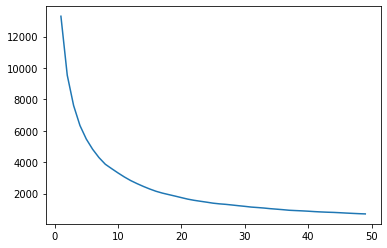

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
tmp_vocab, _ = generate_vocab_map(train_df, cutoff = 2)
len(tmp_vocab)
my_x = np.arange(1, 50, 1)
my_y = []
for x in my_x:
  y, _ = generate_vocab_map(train_df, cutoff = x)
  my_y.append(len(y))
plt.plot(my_x, my_y)

#### 2. Can you describe what cases the model is getting wrong in the witheld test-set? 

Answer: In many cases, the model gets wrong in the test-set with sequences that contains punctuation marks or unknown words (words appear<= cutoff). For instance, ':', '`', and '|' are common in the incorrect sequences. 

To do this, you'll need to create a new val_train_loop (``val_train_loop_incorrect``) so it returns incorrect sequences **and** you'll need to decode these sequences back into words. 
Thankfully, you've already created a map that can convert encoded sequences back to regular English: you will find the ``reverse_vocab`` variable useful.

```
# i.e. using a reversed map of {"hi": 2, "hello": 3, "UNK": 0}
# we can turn [2, 3, 0] into this => ["hi", "hello", "UNK"]
```

In [ ]:
# Implement this however you like! It should look very similar to val_loop.
# Pass the test_iterator through this function to look at errors in the test set.
def val_train_loop_incorrect(model, iterator):
  true, pred = [], []
  regular_english = []
  _, reversed_vocab = generate_vocab_map(train_df)
  temp_size = 0
  model.eval()
  for x, y in tqdm(iterator):
    x = x.to(device)
    x_test_pred = model(x)
    x_pred_bool = torch.round(x_test_pred)
    pred.extend(x_pred_bool.tolist())
    true.extend(y.to(device).tolist())
    true = [float(x) for x in true]
    incorrect = []
    for i in range(temp_size, len(true)):
      if true[i] != pred[i]:
        incorrect.append(x[i-temp_size])
    temp_size = len(true)
    for i in range(0, len(incorrect)):
      for j in range(0, len(incorrect[i])):
        id = incorrect[i][j].item()
        word = reversed_vocab[id]
        regular_english.append(word)

  return regular_english

In [ ]:
val_train_loop_incorrect(model, test_iterator)

100%|██████████| 150/150 [00:00<00:00, 550.77it/s]


['ron',
 'paul',
 'will',
 'make',
 'his',
 'acting',
 '',
 'in',
 '',
 '',
 ':',
 'part',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'car',
 'rolls',
 'up',
 'to',
 '',
 'blasting',
 'google',
 'maps',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'funeral',
 'meal',
 'leaves',
 'at',
 'least',
 '9',
 'dead',
 ',',
 'dozens',
 'sick',
 'in',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'grand',
 'jury',
 'indicted',
 'the',
 'man',
 'who',
 'filmed',
 'eric',
 '',
 '’',
 's',
 'killing',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'new',
 'amazon',
 'service',
 'lets',
 'customers',
 'boost',
 'shipping',
 'speed',
 'with',
 'easy',
 '',
 'charge',
 'to',
 '',
 'delivery',
 'person',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'jeb',
 'bush',
 'at',
 'town',
 'hall',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ''

### Part 6: LSTM Model [Extra-Credit, 4 points]

#### Part 6.1 Define the RecurrentModel class
Something that has been overlooked so far in this project is the sequential structure to language: a word typically only has a clear meaning because of its relationship to the words before and after it in the sequence, and the feed-forward network of Part 2 cannot model this type of data. A solution to this, is the use of [recurrent neural networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). These types of networks not only produce some output given some step from a sequence, but also update their internal state, hopefully "remembering" some information about the previous steps in the input sequence. Of course, they do have their own faults, but we'll cover this more thoroughly later in the semester. 

Your task for the extra credit portion of this assignment, is to implement such a model below using a LSTM. Instead of averaging the embeddings as with the FFN in Part 2, you'll instead feed all of these embeddings to a LSTM layer, get its final output, and use this to make your prediction for the class of the headline. 

In [ ]:
class RecurrentModel(nn.Module):
    # Instantiate layers for your model-
    # 
    # Your model architecture will be an optionally bidirectional LSTM,
    # followed by a linear + sigmoid layer.
    #
    # You'll need 4 nn.Modules
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A bidirectional LSTM (see nn.LSTM)
    # 3. A Linear layer (see nn.Linear)
    # 4. A sigmoid output (see nn.Sigmoid)
    #
    # HINT: In the forward step, the BATCH_SIZE is the first dimension.
    # HINT: Think about what happens to the linear layer's hidden_dim size
    #       if bidirectional is True or False.
    # 
    def __init__(self, vocab_size, embedding_dim, hidden_dim, \
                 num_layers=1, bidirectional=True):
        super().__init__()
        ## YOUR CODE STARTS HERE (~4 lines of code) ##
        # self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True, num_layers= 1, bidirectional = True)
        self.sigmoid = nn.Sigmoid()
        self.linearLayer = nn.Linear(hidden_dim * 2, 1)
        

        ## YOUR CODE ENDS HERE ##
        
    # Complete the forward pass of the model.
    #
    # Use the last timestep of the output of the LSTM as input
    # to the linear layer. This will only require some indexing 
    # into the correct return from the LSTM layer. 
    # 
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed-
    def forward(self, x):
        ## YOUR CODE STARTS HERE (~4-5 lines of code) ##
        embeds = self.embeddings(x)
        # print("forward")
        # print(embeds.size())
        lstm_out, _ = self.lstm(embeds)
        # print(lstm_out.size())
        tag_space = self.linearLayer(lstm_out[:,-1,:])
        # print(tag_space.size())
        tag_scores = self.sigmoid(tag_space)
        # print(tag_scores.size())
        x = torch.flatten(tag_scores)
        # print(x.size())
        
        

        return x
        ## YOUR CODE ENDS HERE ##
    

Now that the RecurrentModel is defined, we'll reinitialize our dataset iterators so they're back at the start. 

In [ ]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

#### Part 6.2 Initialize the LSTM classification model

Next we need to initialize our new model, as well as define it's optimizer and loss function as we did for the FFN. Feel free to use the same optimizer you did above, or see how this model reacts to different optimizers/learning rates than the FFN.  

In [ ]:
lstm_model = RecurrentModel(vocab_size    = len(train_vocab.keys()),
                            embedding_dim = 300,
                            hidden_dim    = 300,
                            num_layers    = 1,
                            bidirectional = True).to(device)

In [ ]:
lstm_criterion, lstm_optimizer = None, None
### YOUR CODE STARTS HERE ###
import torch.optim as optim
lstm_criterion = torch.nn.BCELoss()
lstm_optimizer = optim.Adam(model.parameters(), lr=0.001)


### YOUR CODE ENDS HERE ###

#### Part 6.3 Training and Evaluation

Because the only difference between this model and the FFN is the internal structure, we can use the same methods as above to evaluate and train it. You should be able to achieve a validation F-1 score of at least .8 if everything went correctly. **Feel free to adjust the number of epochs to prevent overfitting or underfitting and to play with your model hyperparameters/optimizer & loss function.**

In [ ]:
#Pre-training to see what accuracy we can get with random parameters
true, pred = val_loop(lstm_model, val_iterator)
print()
print(true)
print(pred)
print(f'Binary Macro F1: {binary_macro_f1(true, pred)}')
print(f'Accuracy: {accuracy(true, pred)}')

100%|██████████| 150/150 [00:05<00:00, 25.94it/s]


[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
#Watch the model train!
TOTAL_EPOCHS = 5
for epoch in range(TOTAL_EPOCHS):
    train_loss = train_loop(lstm_model, lstm_criterion, lstm_optimizer, train_iterator)
    true, pred = val_loop(lstm_model, val_iterator)
    print(f"EPOCH: {epoch}")
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VAL F-1: {binary_macro_f1(true, pred)}")
    print(f"VAL ACC: {accuracy(true, pred)}")

100%|██████████| 150/150 [00:00<00:00, 609.57it/s]


EPOCH: 0
TRAIN LOSS: 77.06274588809902
VAL F-1: 0.8346420486700623
VAL ACC: 0.8441666666666666


100%|██████████| 150/150 [00:00<00:00, 616.13it/s]


EPOCH: 1
TRAIN LOSS: 70.56600791236269
VAL F-1: 0.8332529568991589
VAL ACC: 0.8441666666666666


100%|██████████| 150/150 [00:00<00:00, 659.65it/s]


EPOCH: 2
TRAIN LOSS: 63.390962942175975
VAL F-1: 0.8339624349282794
VAL ACC: 0.8445833333333334


100%|██████████| 150/150 [00:00<00:00, 644.90it/s]


EPOCH: 3
TRAIN LOSS: 59.71186214193949
VAL F-1: 0.8297827069868879
VAL ACC: 0.84


100%|██████████| 150/150 [00:00<00:00, 567.24it/s]

EPOCH: 4
TRAIN LOSS: 54.894557372452255
VAL F-1: 0.8298564931089665
VAL ACC: 0.84


In [ ]:
#See how your model does on the held out data
true, pred = val_loop(lstm_model, test_iterator)
print()
print(f"TEST F-1: {binary_macro_f1(true, pred)}")
print(f"TEST ACC: {accuracy(true, pred)}")

100%|██████████| 150/150 [00:00<00:00, 647.85it/s]


TEST F-1: 0.8369466987474892
TEST ACC: 0.8454166666666667


### Part 7: Submit Your Homework
This is the end. Congratulations!  

Now, follow the steps below to submit your homework in [Gradescope](https://www.gradescope.com/courses/345683):

1. Rename this ipynb file to 'CS4650_p1_GTusername.ipynb'. We recommend ensuring you have removed any extraneous cells & print statements, clearing all outputs, and using the Runtime --> Run all tool to make sure all output is update to date. Additionally, leaving comments in your code to help us understand your operations will assist the teaching staff in grading. It is not a requirement, but is recommended. 
2. Click on the menu 'File' --> 'Download' --> 'Download .py'.
3. Click on the menu 'File' --> 'Download' --> 'Download .ipynb'.
4. Download the notebook as a .pdf document. Make sure the output from Parts 4 & 6.3 are captured so we can see how the loss, F1, & accuracy changes while training.
5. Upload all 3 files to GradeScope.
